<h1 style="justify-content: center; text-align:center"><span class="label label-danger" style="font-size:36px;">DATA VIZ</span></h1><br><br>

<ul class="list-group" style="width:40%; float:left">
  <li class="list-group-item active"><b>Table of Contents</b></li>
  <li class="list-group-item">Part I : Getting ranking per country</li>
  <li class="list-group-item">Part II : Getting beer details</li>
</ul>


<ul class="list-group" style="width:40%; float:right">
  <li class="list-group-item active"><b>Team Members</b></li>
  <li class="list-group-item">Alexis Montavon</li>
  <li class="list-group-item">Boris Flückiger</li>
  <li class="list-group-item">Yu Yamashita</li>
</ul>

In [139]:
from bs4 import BeautifulSoup
import pandas as pd 
import requests
import time
import numpy as np
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from os import listdir
from os.path import isfile, join
from tqdm import tqdm, tqdm_notebook


# PART I

In [2]:
with requests.session() as s:
    response = s.get("https://www.ratebeer.com/beer/country/abkhazia/263/")
    soup = BeautifulSoup(response.text, "html.parser")
    options = soup.find_all('option')
    country_paths = [opt['value'] for opt in options if '/beer/country' in opt['value']]

In [3]:
#Example
country_paths[0]

'/beer/country/abkhazia/263/'

In [4]:
print("There are",len(country_paths), 'countries')

There are 245 countries


In [5]:
def make_url(query_path):
    return ('https://www.ratebeer.com{query}').format(query=query_path)

## Scraping (no need to run twice)

In [98]:
for country in country_paths:
    ctry = country.split('/')[3]
    print("Scraping for {cty}...".format(cty=ctry))
    lst_beer = []
    lst_beer_link = []
    lst_score = []
    lst_style = []
    time.sleep(.3)
    with requests.session() as a:
        response = s.get(make_url(country))
        soup = BeautifulSoup(response.text, "html.parser")
    length_ =  len(soup.find('table').find_all('tr'))
    if length_ > 1:
        for i in range(1,length_):
            lst_beer.append(soup.find('table').find_all('tr')[i].find('a').text)
            lst_beer_link.append(soup.find('table').find_all('tr')[i].find('a')['href'])
            lst_score.append(soup.find('table').find_all('tr')[i].find('b').text) 
            lst_style.append(soup.find('table').find_all('tr')[i].find_all('a')[1].text)
    
    df = pd.DataFrame({'beer': lst_beer, 'link': lst_beer_link, 'score': lst_score, 'style': lst_style})
    file_name = "./Data/country_{c}_ranking.csv".format(c=ctry)
    df.to_csv(file_name, index=False)     

Scraping for abkhazia...
Scraping for afghanistan...
Scraping for albania...
Scraping for algeria...
Scraping for american-samoa...
Scraping for andorra...
Scraping for angola...
Scraping for anguilla...
Scraping for antigua-barbuda...
Scraping for argentina...
Scraping for armenia...
Scraping for aruba...
Scraping for ascension-island...
Scraping for australia...
Scraping for austria...
Scraping for azerbaijan...
Scraping for bahamas...
Scraping for bahrain...
Scraping for bangladesh...
Scraping for barbados...
Scraping for belarus...
Scraping for belgium...
Scraping for belize...
Scraping for benin...
Scraping for bermuda...
Scraping for bhutan...
Scraping for bolivia...
Scraping for bonaire...
Scraping for bosnia-and-herzegovina...
Scraping for botswana...
Scraping for brazil...
Scraping for british-virgin-islands...
Scraping for brunei...
Scraping for bulgaria...
Scraping for burkina-faso...
Scraping for burundi...
Scraping for cambodia...
Scraping for cameroon...
Scraping for cana

# PART II

In [6]:
# Example
abkhazia = pd.read_csv('./Data/country_abkhazia_ranking.csv')
url_beer = make_url(abkhazia.link[5])
url_beer

'https://www.ratebeer.com/beer/sukhumskoe-svetloe-pivo-klassicheskoe/152260/'

In [7]:
def get_beer_details(link):
    '''
    This function enables to get beer details from link.
    '''
    time.sleep(.3)
    with requests.session() as a:
        response = s.get(link)
        soup = BeautifulSoup(response.text, "html.parser")
    if soup.find('abbr', attrs={'title': "Estimated calories for a 12 fluid ounce serving"}) is None:
        abv = soup.find_all('big', attrs={'style':'color: #777;'})[-1].text.split('%')[0]
        cal = np.NaN
    else:
        abv = soup.find_all('big', attrs={'style':'color: #777;'})[-1].text.split('%')[0]
        cal = soup.find_all('big', attrs={'style':'color: #777;'})[-2].text
    
    name = soup.find('span', attrs={'itemprop': 'name'}).text.strip() #find the name without encoding bug
    beer_style = soup.select("a[href*=beerstyles]")[-1].text #find the beer style without the encoding bug
    
    loc = soup.find_all('div', attrs={'style':'padding-bottom: 7px; line-height: 1.5;'})[0].find_all('br')[-1].text
    city = loc.split(',')[:-1]
    country =  loc.split(',')[-1].strip()

    return abv,cal,city,country,name,beer_style
    

In [8]:
# Example
a,c,l,co,nam,st = get_beer_details('https://www.ratebeer.com/beer/svejk-dark/220898/')
c

nan

## Loading paths to CSVs

In [9]:
ROOT = "./Data/"

def get_all_files_in(mypath):
    return [f for f in listdir(mypath) if isfile(join(mypath, f))]

paths_csv = [ROOT + file_path for file_path in get_all_files_in(ROOT)]
paths_csv.remove('./Data/.DS_Store')

## Scraping beer details (no need to run twice)

In [10]:
lst_df = []
for j in tqdm_notebook(range(len(paths_csv))):
    path = paths_csv[j]
    lst_abv = []
    lst_cal = []
    lst_city = []
    lst_country = []
    lst_name = []
    lst_style = []
    df = pd.read_csv(path)
    urls_beer = [make_url(query) for query in df.link]
    for url_ in urls_beer:
        try:
            abv,cal,city,country,name,style = get_beer_details(url_)
            lst_abv.append(abv)
            lst_cal.append(cal)
            lst_city.append(city)
            lst_country.append(country)
            lst_name.append(name)
            lst_style.append(style)
        except:
            print("null entry with :", url_)
            lst_abv.append(np.NaN)
            lst_cal.append(np.NaN)
            lst_city.append(np.NaN)
            lst_country.append(np.NaN)
            lst_name.append(np.NaN)
            lst_style.append(np.NaN)
    df['abv'] = lst_abv
    df['cal'] = lst_cal
    df['city'] = lst_city
    df['country'] = lst_country
    df['name'] = lst_name
    df['beer style'] = lst_style
    lst_df.append(df) 

null entry with : https://www.ratebeer.com/beer/balashi-pilsener/296383/
null entry with : https://www.ratebeer.com/beer/baki-castel-33-export-azerbaijan/57932/
null entry with : https://www.ratebeer.com/beer/guinness-foreign-extra-stout-belize/278682/
null entry with : https://www.ratebeer.com/beer/bhutan-premium-lager-beer/111662/
null entry with : https://www.ratebeer.com/beer/carling-black-label-beer-botswana/243056/
null entry with : https://www.ratebeer.com/beer/kgalagadi-ohlssons/41321/
null entry with : https://www.ratebeer.com/beer/guinness-foreign-extra-stout-burkina-faso/423683/
null entry with : https://www.ratebeer.com/beer/artisanale-de-ouagadougou-make-beer-not-cars/508602/
null entry with : https://www.ratebeer.com/beer/guinness-foreign-extra-stout-cameroon/272062/
null entry with : https://www.ratebeer.com/beer/cubanero-fuerte/234507/
null entry with : https://www.ratebeer.com/beer/palma-cristal/12457/
null entry with : https://www.ratebeer.com/beer/skol-congo-dr/59432

In [190]:
df_all = pd.concat(lst_df, ignore_index=True)
df_all = df_all.drop(['beer', 'style'], axis=1)

In [191]:
df_all =  df_all[['name','score','beer style','abv','cal','city','country','link']]
df_all.head()

,name,score,beer style,abv,cal,city,country,link
0,Ivanych Zhivoe Svetloe,2.84,Zwickel/Keller/Landbier,4.5,135,[Sukhum],Abkhazia,/beer/ivanych-zhivoe-svetloe/301247/
1,Stara Praha Oldenburg Tiemnoye,2.52,Dunkel/Tmavý,4.7,141,[Stara Gagra],Abkhazia,/beer/stara-praha-oldenburg-tiemnoye/334787/
2,Stara Praha Oldenburg Svetloe,2.51,Pale Lager,4.7,141,[Stara Gagra],Abkhazia,/beer/stara-praha-oldenburg-svetloe/334785/
3,Stara Praha Oldenburg Jantarnoye,2.49,Amber Lager/Vienna,4.5,135,[Stara Gagra],Abkhazia,/beer/stara-praha-oldenburg-jantarnoye/334786/
4,Assir Lager (Svetloe),2.37,Pale Lager,5,150,"[Alakhadzykh Village, Gagra Region]",Abkhazia,/beer/assir-lager-svetloe/191169/


In [192]:
df_all.city = df_all['city'].str.join('')

In [193]:
df_all.cal = pd.to_numeric(df_all['cal'], errors='coerce')
df_all.abv = pd.to_numeric(df_all['abv'], errors='coerce')
df_all.score = pd.to_numeric(df_all['score'], errors='coerce')

In [194]:
df_all.head()

,name,score,beer style,abv,cal,city,country,link
0,Ivanych Zhivoe Svetloe,2.84,Zwickel/Keller/Landbier,4.5,135.0,Sukhum,Abkhazia,/beer/ivanych-zhivoe-svetloe/301247/
1,Stara Praha Oldenburg Tiemnoye,2.52,Dunkel/Tmavý,4.7,141.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-tiemnoye/334787/
2,Stara Praha Oldenburg Svetloe,2.51,Pale Lager,4.7,141.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-svetloe/334785/
3,Stara Praha Oldenburg Jantarnoye,2.49,Amber Lager/Vienna,4.5,135.0,Stara Gagra,Abkhazia,/beer/stara-praha-oldenburg-jantarnoye/334786/
4,Assir Lager (Svetloe),2.37,Pale Lager,5.0,150.0,Alakhadzykh Village Gagra Region,Abkhazia,/beer/assir-lager-svetloe/191169/


In [195]:
type(df_all.score[1])

numpy.float64

In [196]:
df_all.to_csv('ratebeer_dataset_all.csv', index=False)

## EDA

In [197]:
df = pd.read_csv('./ratebeer_dataset_all.csv')

In [200]:
df.shape

(5897, 8)

In [199]:
df[df.score.isnull()].shape

(371, 8)

In [201]:
df = df.dropna(axis=0, how='any')
df.shape

(5006, 8)

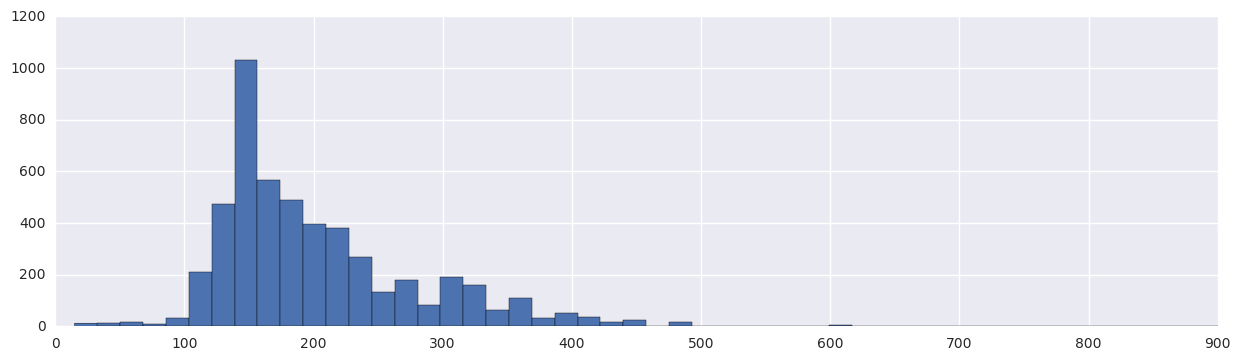

In [202]:
plt.figure(figsize=(15,4))
df.cal.hist(bins=50)

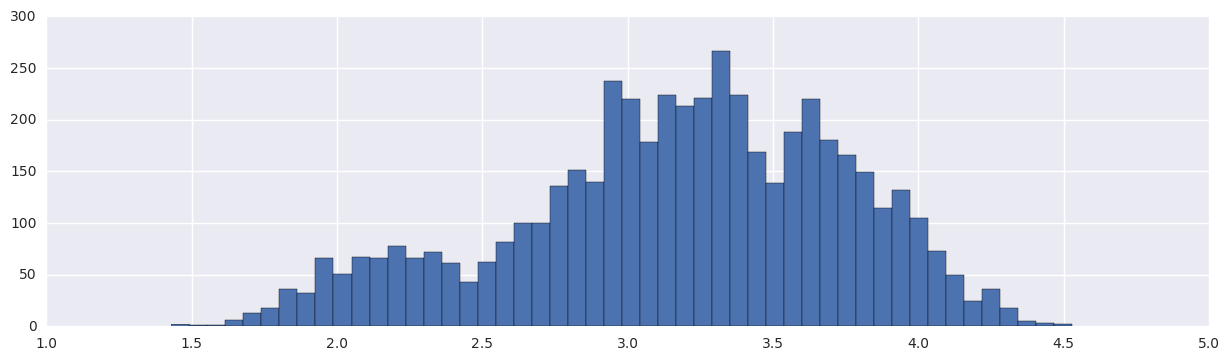

In [203]:
plt.figure(figsize=(15,4))
df.score.hist(bins=50)

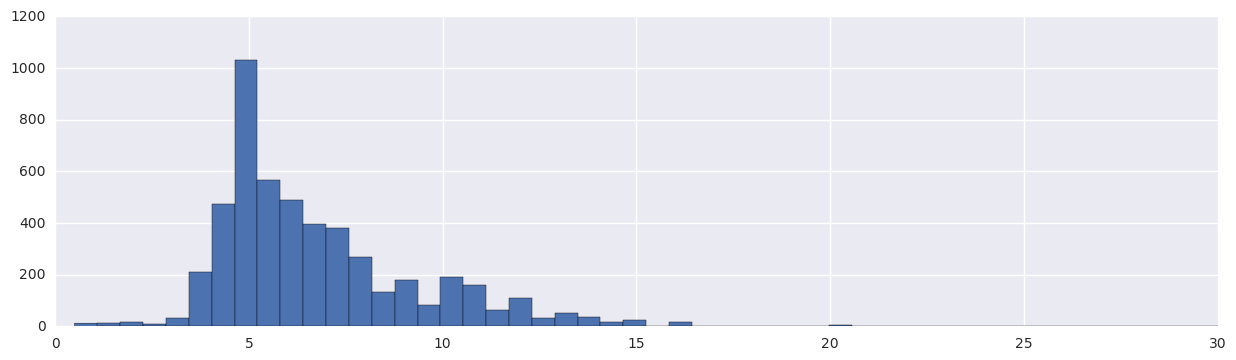

In [204]:
plt.figure(figsize=(15,4))
df.abv.hist(bins=50)

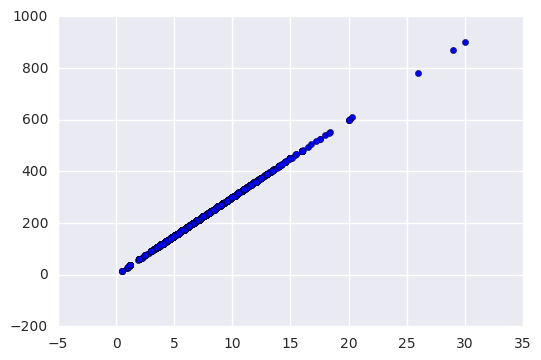

In [210]:
plt.scatter(df.abv,df.cal)

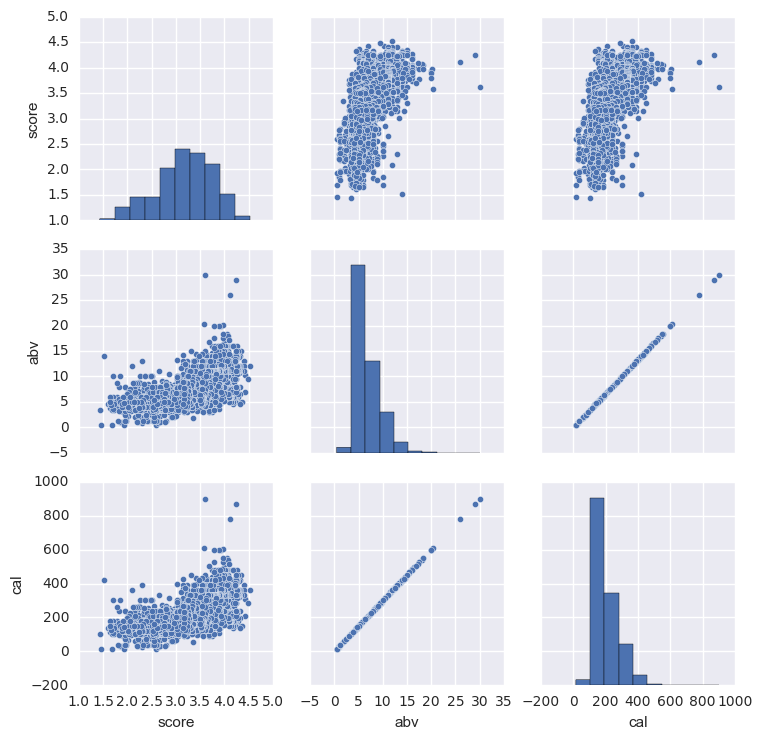

In [211]:
sns.pairplot(df)

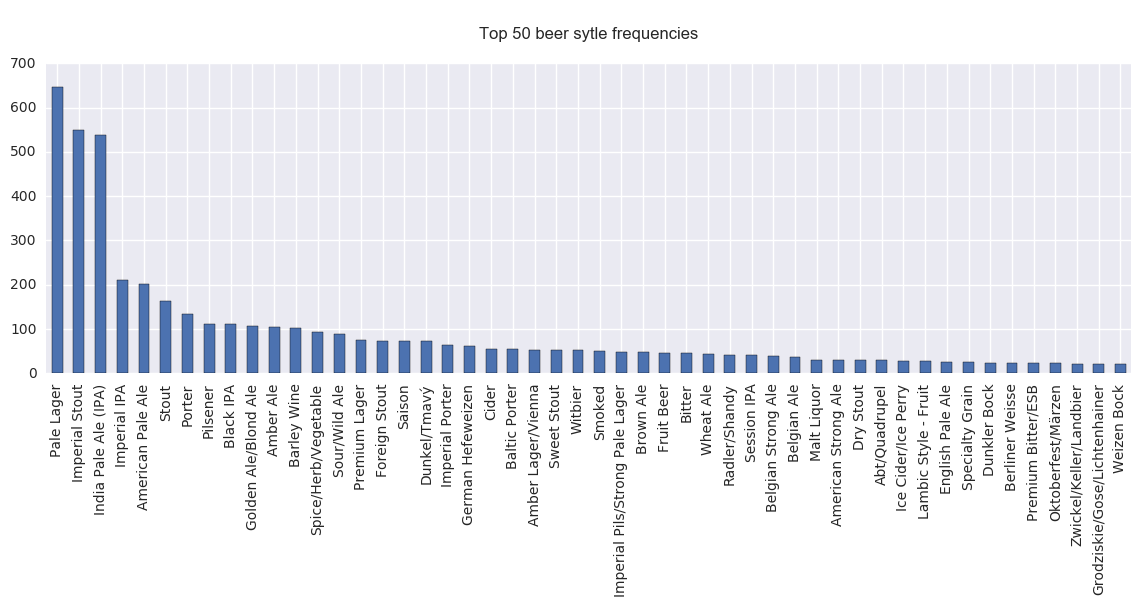

In [215]:
df['beer style'].value_counts()[:50].plot(
    kind='bar', title="\nTop 50 beer sytle frequencies\n", legend=False, figsize=(14,4))

In [244]:
df[df.country.str.contains('USA')]

,name,score,beer style,abv,cal,city,country,link
5570,Toppling Goliath Kentucky Brunch,4.53,Imperial Stout,12.00,360.0,Decorah,Iowa USA,/beer/toppling-goliath-kentucky-brunch/166019/
5572,Goose Island Beer Company (AB-InBev),4.41,Imperial Stout,13.00,390.0,Chicago,Illinois USA,/beer/goose-island-bourbon-county-stout-rare-2...
5573,Toppling Goliath Mornin' Delight,4.40,Imperial Stout,12.00,360.0,Decorah,Iowa USA,/beer/toppling-goliath-mornin-delight/151817/
5574,Cigar City Hunahpu's Imperial Stout - Double B...,4.40,Imperial Stout,11.00,330.0,Tampa,Florida USA,/beer/cigar-city-hunahpus-imperial-stout-doubl...
5575,New Glarus Brewing Company,4.36,Sour/Wild Ale,5.00,150.0,New Glarus,Wisconsin USA,/beer/new-glarus-r-d-sour-fruit-wild-blackberr...
5576,Three Floyds Dark Lord Russian Imperial Stout ...,4.35,Imperial Stout,15.00,450.0,Munster,Indiana USA,/beer/three-floyds-dark-lord-russian-imperial-...
5577,Russian River Pliny the Younger,4.35,Imperial IPA,11.00,330.0,Santa Rosa,California USA,/beer/russian-river-pliny-the-younger/43181/
5578,AleSmith Speedway Stout - Bourbon Barrel Aged,4.33,Imperial Stout,12.00,360.0,San Diego,California USA,/beer/alesmith-speedway-stout-bourbon-barrel-a...
5579,Three Floyds Dark Lord Russian Imperial Stout ...,4.33,Imperial Stout,14.00,420.0,Munster,Indiana USA,/beer/three-floyds-dark-lord-russian-imperial-...
5580,Cigar City Brewing,4.32,Berliner Weisse,4.50,135.0,Tampa,Florida USA,/beer/cigar-city-pilot-series-miami-madness/16...


## Test / Draft (don't need to run)

In [51]:
with requests.session() as a:
    response = s.get('https://www.ratebeer.com/beer/svejk-dark/220898/')
    soup = BeautifulSoup(response.text, "html.parser")

In [52]:
soup.select("a[href*=beerstyles]")[-1].text

'Dunkel/Tmavý'

In [54]:
soup.find('abbr', attrs={'title': "Estimated calories for a 12 fluid ounce serving"}) is None

True

In [371]:
soup.find_all('div', attrs={'style':'padding-bottom: 7px; line-height: 1.5;'})[0].find_all('br')[-1]

<br>Sukhum, Abkhazia                        </br>

In [367]:
soup.find_all('div', attrs={'style':'padding-bottom: 7px; line-height: 1.5;'})[0].find_all('br')[-1].text

'Andorra La Vella, Andorra                         '

In [291]:
soup.find_all('big', attrs={'style':'color: #777;'})[-2]

<big style="color: #777;">108</big>

In [ ]:
abv = soup.find_all('big')[5].text.split('%')[0]
cal = soup.find_all('big')[4].text
loc = [l.strip() for l in soup.find('div', attrs={'class':'description-box'}).find('br').find('br').text.strip().split(',')[:-1]]
country = soup.find('div', attrs={'class':'description-box'}).find('br').find('br').text.strip().split(',')[-1].strip()

In [173]:
cal = soup.find_all('big')[4].text #150

In [186]:
soup.find('div', attrs={'class':'description-box'}).find('br').find('br').text.strip().split(',')

['Durrës', ' Albania']

In [ ]:
loc = soup.find('div', attrs={'class':'description-box'}).find('br').find('br').text.strip().split(',')[0]
country = soup.find('div', attrs={'class':'description-box'}).find('br').find('br').text.strip().split(',')[1].strip()